# This notebook reproduces the main results in Figures 3&4 and the associated Supplementary Figures.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scanpy as sc
import celltypist

In [2]:
adata = sc.read('Lung_four_datasets.h5ad')
del adata.var
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp
adata

AnnData object with n_obs × n_vars = 479135 × 2186
    obs: 'Donor', 'Disease', 'Category', 'Original_annotation', 'Dataset', 'nGenes', 'nUMIs', 'Processing_site', 'Age', 'Location', 'Smoking', 'my_anno', 'combn', 'Group'

Scaled gene expression is in `.X`, and normalised expression is in `.raw`.

Perform a classical workflow: PCA -> neighborhood graph -> UMAP

In [3]:
del adata.raw
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Examine batches.

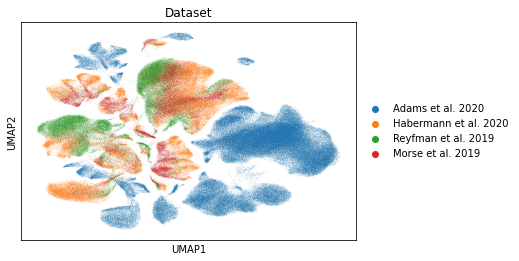

In [4]:
sc.pl.umap(adata, color = 'Dataset')

Examine original annotations (combined status of cell type and disease).

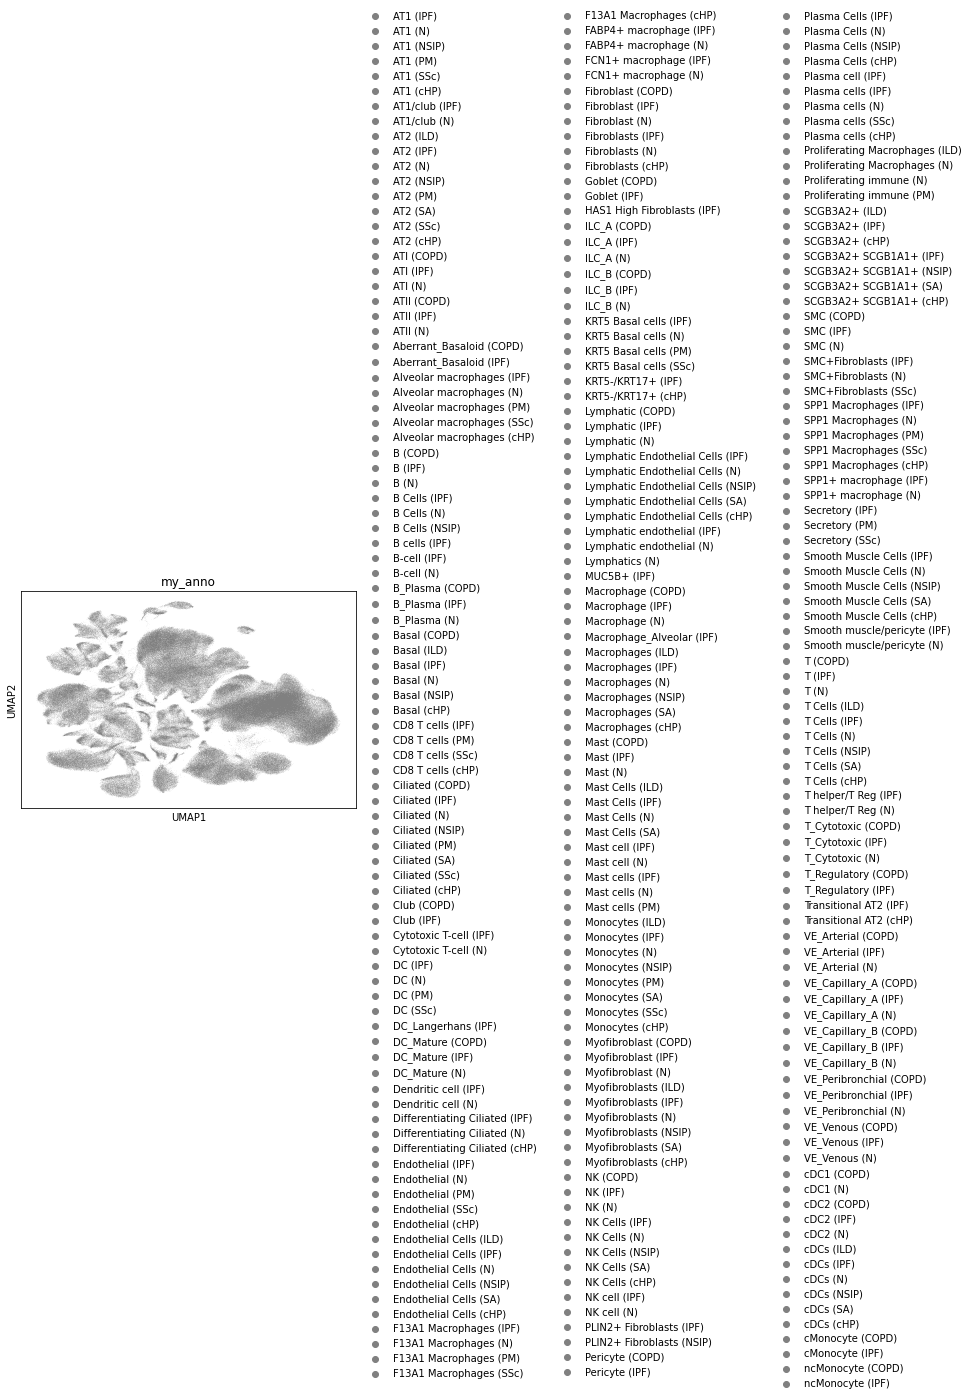

In [5]:
sc.pl.umap(adata, color = 'my_anno')

Use CellTypist to unify this huge number of cell states by cell type harmonisation.

In [6]:
alignment = celltypist.harmonize(adata, 'Dataset', 'my_anno', use_pct = True, dataset_order = ['Adams et al. 2020', 'Morse et al. 2019', 'Habermann et al. 2020', 'Reyfman et al. 2019'])

👀 Detected PCA coordinates in the object, will use these to calculate distances
🏋️ Training the predictive clustering trees for:
      Adams et al. 2020
      Habermann et al. 2020
      Morse et al. 2019
      Reyfman et al. 2019
🖋️ Predicting distances using the PCT in each dataset
🖇 Harmonizing cell types of Adams et al. 2020 and Morse et al. 2019
🖇 Harmonizing cell types of Habermann et al. 2020
🖇 Harmonizing cell types of Reyfman et al. 2019
🖋️ Reannotating cells
✅ Harmonization done!


Save the harmonisation result. Since in this part only the harmonisation table is needed, write out the table.

In [ ]:
alignment.relation.to_csv('Lung_alignment.csv', index = False)

In [7]:
del adata
del alignment

Manually reorder the rows of the table for visualisation purpose. After that, load the harmonisation result and visualise it.

In [8]:
all_relation = pd.read_csv('Lung_alignment.csv')

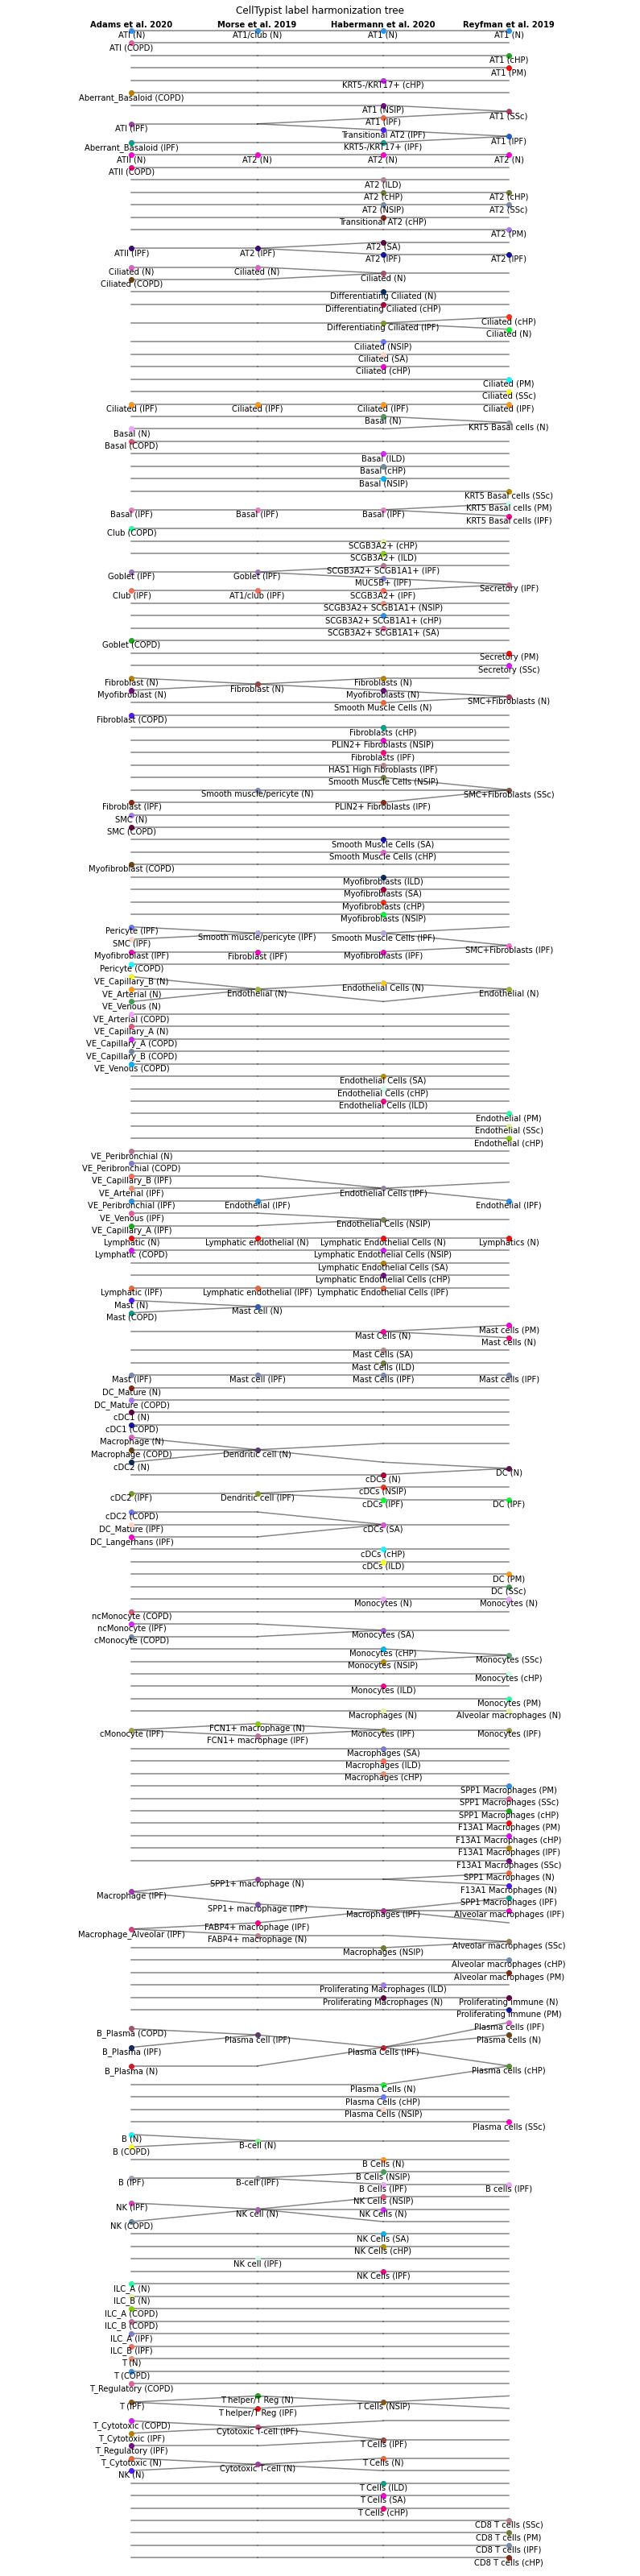

In [9]:
celltypist.treeplot(all_relation)

Get subsets of the harmonisation table corresponding to epithelial, stromal, and immune cell types.

In [10]:
epi = all_relation.iloc[0:52]
stro = all_relation.iloc[52:102]
immune = all_relation.iloc[102:]

Visualise each compartment.

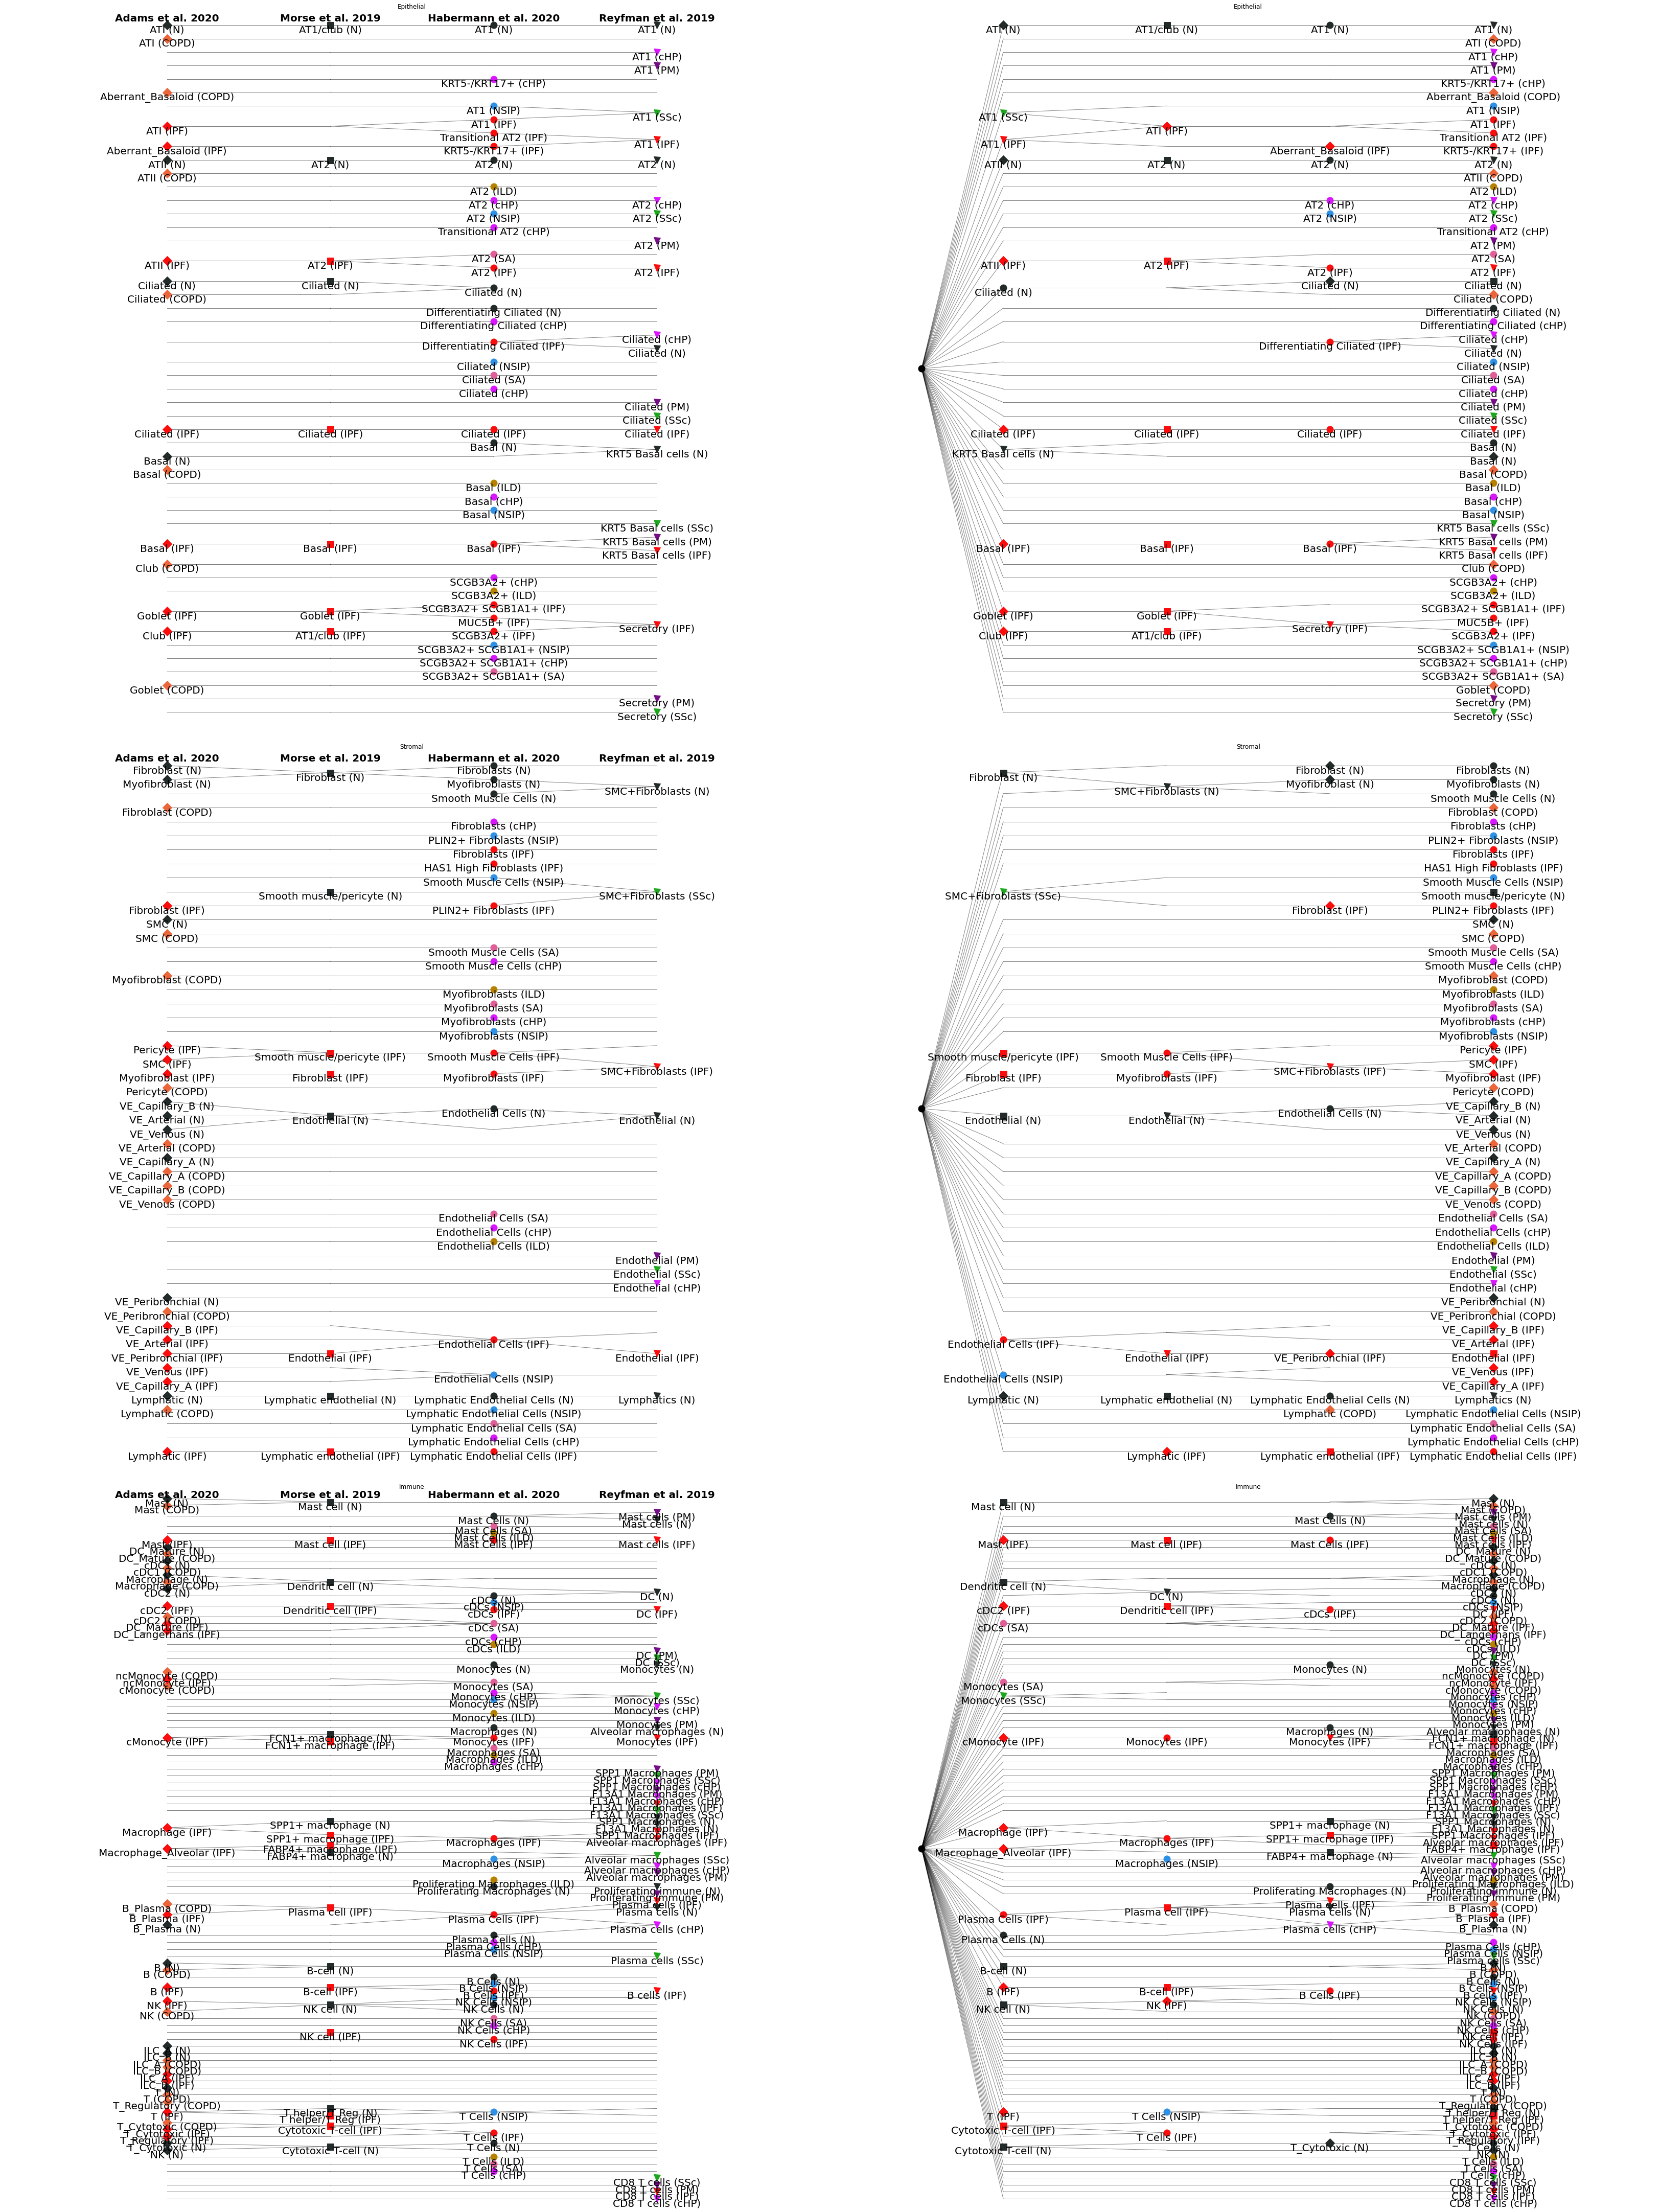

In [11]:
fig, axs = plt.subplots(3, 2, figsize = [45, 60], constrained_layout = True)
for i in [0, 1, 2]:
    relation = [epi, stro, immune][i]
    title = ['Epithelial', 'Stromal', 'Immune'][i]
    node_color = pd.DataFrame(columns = ['dataset', 'cell_type', 'color'])
    for dataset in relation.columns[::2]:
        for row in relation.index:
            content = relation.loc[row, dataset]
            if content in ['NONE', 'UNRESOLVED']:
                continue
            if '(N)' in content:
                color = '#222A2A'
            elif '(IPF)' in content:
                color = '#FB0D0D'
            elif '(SA)' in content:
                color = '#E15F99'
            elif '(ILD)' in content:
                color = '#B68100'
            elif '(cHP)' in content:
                color = '#DA16FF'
            elif '(NSIP)' in content:
                color = '#2E91E5'
            elif '(SSc)' in content:
                color = '#1CA71C'
            elif '(PM)' in content:
                color = '#750D86'
            elif '(COPD)' in content:
                color = '#EB663B'
            else:
                raise Exception
            node_color = pd.concat([node_color, pd.DataFrame(dict(dataset=[dataset], cell_type=[content], color=[color]))]).drop_duplicates()
    celltypist.treeplot(relation, order_dataset = False, node_shape = ['D', 's', 'o', 'v'], node_color = node_color, node_size = 13, label_size = 20, link_width = 1, title = title, show = False, ax = axs[i, 0])
    celltypist.treeplot(relation, order_dataset = True,  node_shape = ['D', 's', 'o', 'v'], node_color = node_color, node_size = 13, label_size = 20, link_width = 1, title = title, show = False, ax = axs[i, 1])

Examine some cell type groups (pathological alveolar epithelial cell types as an example).

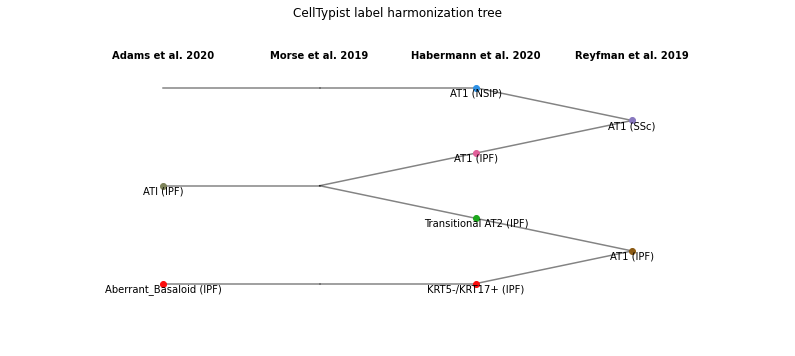

In [12]:
celltypist.treeplot(epi.iloc[[6,7,8,9]], figsize = [14, 6])

Perform label transfer to check the correspondence between "Aberrant_Basaloid" and "KRT5-/KRT17+".

In [13]:
adata = sc.read('Lung_four_datasets.h5ad').raw.to_adata()
adata = adata[(adata.obs.Dataset == 'Habermann et al. 2020') & adata.obs.my_anno.isin(['AT1 (NSIP)', 'AT1 (IPF)', 'Transitional AT2 (IPF)', 'KRT5-/KRT17+ (IPF)'])].copy()
predictions = celltypist.annotate(adata, 'Adamsetal.2020_2_criteria.pkl')

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1209 cells and 20551 genes
🔗 Matching reference genes in the model
🧬 5069 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


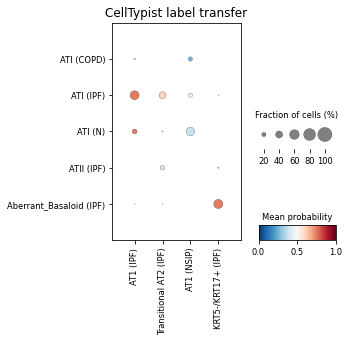

In [14]:
celltypist.dotplot(predictions, 'my_anno', 'predicted_labels', figsize = [4,4], prediction_order = ['ATI (COPD)', 'ATI (IPF)', 'ATI (N)', 'ATII (IPF)', 'Aberrant_Basaloid (IPF)'])

Examine pathological features (using PF signature as an example).

In [15]:
def lung_gene_score(adata, relation, gene_set):
    #all cell types
    all_celltypes = []
    for dataset in relation.columns[::2]:
        for row in relation.index:
            content = relation.loc[row, dataset]
            if content in ['NONE', 'UNRESOLVED']:
                continue
            all_celltypes.append(f"{dataset}: {content}")
    all_celltypes = np.unique(all_celltypes)
    #adata
    adata.obs['combn'] = adata.obs.Dataset.astype(str) + ': ' + adata.obs.my_anno.astype(str)
    adata = adata[adata.obs.combn.isin(all_celltypes)].copy()
    #gene set
    if isinstance(gene_set, str):
        gene_set = [gene_set]
    gene_set = np.intersect1d(gene_set, adata.var_names)
    assert len(gene_set) > 0
    sc.tl.score_genes(adata, gene_set)
    #df
    df = adata.obs[['Dataset', 'my_anno', 'combn']].drop_duplicates().copy()
    df['value'] = [adata[adata.obs.combn == x].obs.score.mean() for x in df.combn.values]
    #return
    df['Dataset'] = df.Dataset.astype(str)
    df['my_anno'] = df.my_anno.astype(str)
    return df[['Dataset', 'my_anno', 'value']]

In [16]:
relation = pd.read_csv('Lung_alignment.csv')[:19]
adata = sc.read('Lung_four_datasets.h5ad').raw.to_adata()
gene_set = ['CDKN2A', 'COL1A1', 'FN1', 'MMP7', 'MUC5B', 'SMAD3', 'ITGB6', 'GDF15', 'EPHB2']
node_color = lung_gene_score(adata, relation, gene_set)

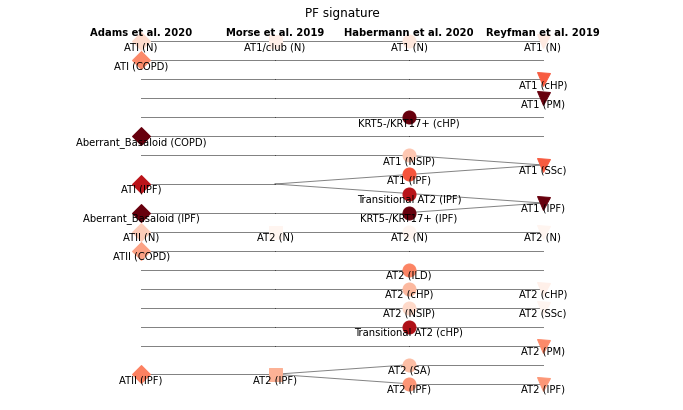

In [17]:
celltypist.treeplot(relation, order_dataset = False, node_shape = ['D', 's', 'o', 'v'], node_color = node_color, node_size = 13, label_size = 10, figsize = [12, 7], link_width = 1, title = 'PF signature')

Perform differential expression analysis (pathological alveolar epithelial cell types as an example).

In [1]:
def scanpy_DE(adata, celltype_column, celltypes = None, pct1 = 0.4, pct2 = 0.2, **kwargs):
    if celltypes is None:
        celltypes = np.unique(adata.obs[celltype_column])
    sub_adata = adata[adata.obs[celltype_column].isin(celltypes)].copy()
    sc.tl.rank_genes_groups(sub_adata, groupby = celltype_column, pts = True, **kwargs)
    genes = sub_adata.var_names
    pcts = sub_adata.uns['rank_genes_groups']['pts']
    pcts_rest = sub_adata.uns['rank_genes_groups']['pts_rest']
    assert np.all(genes == pcts.index)
    assert np.all(genes == pcts_rest.index)
    result = sub_adata.uns['rank_genes_groups']
    #main
    interests = result['names'].dtype.names
    final_df = pd.DataFrame(columns = ['pct', 'pct_rest', 'logfoldchanges', 'pvals', 'pvals_adj', 'gene', 'cell_type'])
    for interest in interests:
        df1 = pd.DataFrame({'pct': pcts[interest], 'pct_rest': pcts_rest[interest]}, index = genes)
        df2 = pd.DataFrame({x: result[x][interest] for x in ('logfoldchanges', 'pvals', 'pvals_adj')}, index = result['names'][interest]).loc[genes]
        df = df1.join(df2)
        df.sort_values(['pvals_adj', 'logfoldchanges'], ascending = [True, False], inplace = True)
        df['gene'] = df.index
        df['cell_type'] = interest
        df = df[(df.pct > pct1) & (df.pct_rest < pct2)]
        if df.shape[0] > 0:
            final_df = final_df.append(df, ignore_index = True, sort = False)
    return final_df

Group cell types and diseases based on the cell type hierarchy, and visualise selected genes with pathological relevance.

... storing 'combn' as categorical


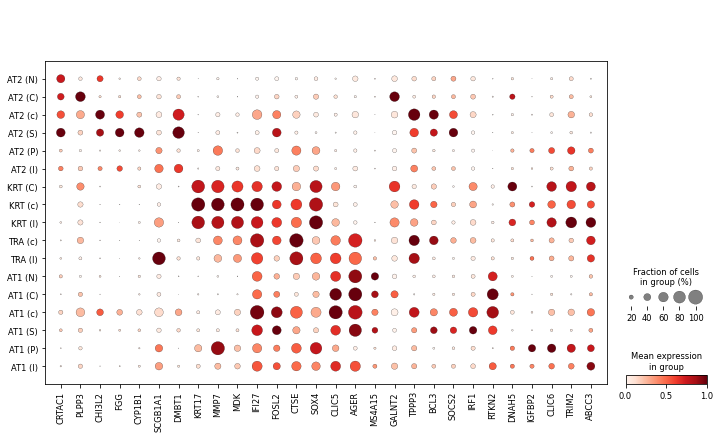

In [4]:
adata.obs['combn'] = adata.obs.Dataset.astype(str) + '___' + adata.obs.my_anno.astype(str)
kept_celltypes = {
                   'AT2 (N)': ['Adams et al. 2020___ATII (N)', 'Morse et al. 2019___AT2 (N)', 'Habermann et al. 2020___AT2 (N)', 'Reyfman et al. 2019___AT2 (N)'],
                   'AT2 (C)': ['Adams et al. 2020___ATII (COPD)'],
                   'AT2 (c)': ['Habermann et al. 2020___AT2 (cHP)', 'Reyfman et al. 2019___AT2 (cHP)'],
                   'AT2 (S)': ['Reyfman et al. 2019___AT2 (SSc)', 'Habermann et al. 2020___AT2 (NSIP)'],
                   'AT2 (P)': ['Reyfman et al. 2019___AT2 (PM)'],
                   'AT2 (I)': ['Adams et al. 2020___ATII (IPF)', 'Morse et al. 2019___AT2 (IPF)', 'Habermann et al. 2020___AT2 (IPF)', 'Reyfman et al. 2019___AT2 (IPF)'],
                   'KRT (C)': ['Adams et al. 2020___Aberrant_Basaloid (COPD)'],
                   'KRT (c)': ['Habermann et al. 2020___KRT5-/KRT17+ (cHP)'],
                   'KRT (I)': ['Adams et al. 2020___Aberrant_Basaloid (IPF)', 'Habermann et al. 2020___KRT5-/KRT17+ (IPF)'],
                   'TRA (c)': ['Habermann et al. 2020___Transitional AT2 (cHP)'],
                   'TRA (I)': ['Habermann et al. 2020___Transitional AT2 (IPF)'],
                   'AT1 (N)': ['Adams et al. 2020___ATI (N)', 'Habermann et al. 2020___AT1 (N)', 'Reyfman et al. 2019___AT1 (N)'],
                   'AT1 (C)': ['Adams et al. 2020___ATI (COPD)'],
                   'AT1 (c)': ['Reyfman et al. 2019___AT1 (cHP)'],
                   'AT1 (S)': ['Reyfman et al. 2019___AT1 (SSc)', 'Habermann et al. 2020___AT1 (NSIP)'],
                   'AT1 (P)': ['Reyfman et al. 2019___AT1 (PM)'],
                   'AT1 (I)': ['Adams et al. 2020___ATI (IPF)', 'Habermann et al. 2020___AT1 (IPF)', 'Reyfman et al. 2019___AT1 (IPF)'],
                 }
all_celltypes = list({x for key in kept_celltypes for x in kept_celltypes[key]})
adata = adata[adata.obs.combn.isin(all_celltypes)].copy()
adata.obs['group'] = 'XXX'
for key in kept_celltypes:
    adata.obs.loc[adata.obs.combn.isin(kept_celltypes[key]), 'group'] = key
adata.obs['group'] = adata.obs['group'].astype('category')
adata.obs['group'].cat.reorder_categories([x for x in kept_celltypes], inplace = True)

#df = scanpy_DE(adata, 'group')
#genes are selected based on the above list
genes = ['CRTAC1', 'PLPP3', 'CHI3L2', 'FGG', 'CYP1B1', 'SCGB1A1', 'DMBT1', 'KRT17', 'MMP7', 'MDK',
         'IFI27', 'FOSL2', 'CTSE', 'SOX4',
         'CLIC5', 'AGER', 'MS4A15', 'GALNT2', 'TPPP3', 'BCL3', 'SOCS2', 'IRF1', 'RTKN2', 'DNAH5', 'IGFBP2', 'CLIC6', 'TRIM2', 'ABCC3']
sc.pl.dotplot(adata, genes, 'group', cmap = 'Reds', standard_scale = 'var', swap_axes = False)